In [15]:
%reload_ext autoreload
%autoreload 2

import os, sys
sys.path.append('..')

import numpy as np
from tqdm import tqdm
import time

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

In [2]:
# 21cmFAST
import py21cmfast as p21c
from py21cmfast import plotting, cache_tools
print(f'Using 21cmFAST version {p21c.__version__}')

import logging
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:59: UserWarning: Your configuration file is out of date. Updating...
  "Your configuration file is out of date. Updating..."
/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


Using 21cmFAST version 0.1.dev1578+g6f96f89.d20230224


In [5]:
from dm21cm.injection import DMParams, get_input_boxs

## 0. Global config

In [6]:
! lscpu | grep "CPU(s)"

CPU(s):                48
On-line CPU(s) list:   0-47
NUMA node0 CPU(s):     0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46
NUMA node1 CPU(s):     1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47


In [7]:
N_THREADS = 32

## 1. Run

In [8]:
def get_z_arr(z_start=p21c.global_params.Z_HEAT_MAX, z_end=20):
    
    z_arr = [z_end]
    while np.max(z_arr) < z_start:
        z_prev = (1 + np.max(z_arr)) * p21c.global_params.ZPRIME_STEP_FACTOR - 1
        z_arr.append(z_prev)
    return np.array(z_arr[::-1][1:])

In [9]:
# check cached runs
CACHE_DIR_BASE = '/scratch/submit/ctp/yitians/21cmFAST-cache'
os.listdir(CACHE_DIR_BASE)

['DH', 'dh', 'baseline']

In [10]:
# run config
RUN_NAME = 'DH'
f_scheme = 'DH'
run_mode = 'inj'

p21c.config['direc'] = f'{CACHE_DIR_BASE}/{RUN_NAME}'
os.makedirs(p21c.config['direc'], exist_ok=True)

In [ ]:
cache_tools.clear_cache()

In [17]:
# initialize
initial_conditions = p21c.initial_conditions(
    user_params = p21c.UserParams(
        HII_DIM=50, # [1]
        BOX_LEN=50, # [p-Mpc]
        N_THREADS=N_THREADS
    ),
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=54321, write=True
)

# redshift
p21c.global_params.ZPRIME_STEP_FACTOR = 1.05
z_arr = get_z_arr(z_end=5)
print(z_arr)

# dark matter
dm_params = DMParams(mode='swave', channel='phph', m_DM=4e6, sigmav=1e-26)

/work/submit/yitians/anaconda3/envs/21cmfast/lib/python3.7/site-packages/py21cmfast/inputs.py:488: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  "The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be "


[33.75089682 32.09609221 30.52008781 29.01913125 27.58964881 26.22823696
 24.93165425 23.69681357 22.52077483 21.40073793 20.33403613 19.31812965
 18.35059966 17.42914254 16.55156432 15.71577554 14.91978623 14.16170117
 13.4397154  12.75210991 12.09724753 11.47356908 10.8795896  10.31389485
  9.77513796  9.26203615  8.77336776  8.3079693   7.86473266  7.44260254
  7.04057384  6.65768938  6.2930375   5.94575     5.615       5.3
  5.        ]


In [13]:
logging.getLogger('py21cmfast._utils').setLevel(logging.CRITICAL+1)
logging.getLogger('py21cmfast.wrapper').setLevel(logging.CRITICAL+1)

In [18]:
records = []
i_slice = int(initial_conditions.user_params.HII_DIM/2)
input_time_tot = 0.
p21c_time_tot = 0.

for i_z in tqdm(range(len(z_arr))):

    z = z_arr[i_z]
    
    input_timer = time.time()
    if i_z == 0:
        spin_temp = None
        input_heating = input_ionization = input_jalpha = None
    
    else: ## input from second step
        
        input_heating = p21c.input_heating(redshift=z, init_boxes=initial_conditions, write=False)
        input_ionization = p21c.input_ionization(redshift=z, init_boxes=initial_conditions, write=False)
        input_jalpha = p21c.input_jalpha(redshift=z, init_boxes=initial_conditions, write=False)

        if run_mode == '':
            if i_z == 1:
                logger.warn('Not injecting anything in this run!')

        elif run_mode == 'circle':
            input_heating.input_heating += get_circle_seq_at(LOWRES_DIM, 3, i_z)
            input_ionization.input_ionization += get_circle_seq_at(LOWRES_DIM, 5, 9-i_z) * 1e-3
            input_jalpha.input_jalpha += get_circle_seq_at(LOWRES_DIM, 6, 35-i_z)

        else:
            z_prev = z_arr[i_z-1]
            
            input_boxs = get_input_boxs(
                delta_box = perturbed_field.density, # [1]
                x_e_box = 1 - ionized_box.xH_box, # [1]
                z_prev = z_arr[i_z-1],
                z = z,
                dm_params = dm_params,
                f_scheme=f_scheme,
            )

            input_heating.input_heating += input_boxs['heat']
            input_ionization.input_ionization += input_boxs['ion']
            #input_jalpha.input_jalpha += input_boxs['exc']
    input_time_tot += time.time() - input_timer

    ## step in 21cmFAST
    p21c_timer = time.time()
    perturbed_field = p21c.perturb_field( # perturbed_field controls the redshift
        redshift=z,
        init_boxes=initial_conditions
    )
    spin_temp = p21c.spin_temperature(
        perturbed_field=perturbed_field,
        previous_spin_temp=spin_temp,
        input_heating_box=input_heating,
        input_ionization_box=input_ionization,
        input_jalpha_box=input_jalpha,
        write=True
    )
    ionized_box = p21c.ionize_box(
        spin_temp=spin_temp
    )
    brightness_temp = p21c.brightness_temperature(
        ionized_box=ionized_box,
        perturbed_field=perturbed_field,
        spin_temp=spin_temp
    )
    p21c_time_tot += time.time() - p21c_timer

    ## save results
    record = {
        'delta' : perturbed_field.density[i_slice],
        'T_s'   : spin_temp.Ts_box[i_slice],
        'T_b'   : brightness_temp.brightness_temp[i_slice], # [mK]
        'x_e'   : 1 - ionized_box.xH_box[i_slice],
        #'heat'  : ( dE_inj_per_B_box * f_boxs['heat'] / dt )[i_slice], # [eV s^-1 per B] | dE/dt per B
        #'ion'   : ( dE_inj_per_B_box * f_boxs['ion']  / dt )[i_slice], # [eV s^-1 per B] | dE/dt per B
        #'exc'   : input_jalpha.input_jalpha[i_slice],
    }
    records.append(record.copy())
    
print(f'input used {input_time_tot:.4f} s')
print(f'p21c used {p21c_time_tot:.4f} s')

100%|██████████| 37/37 [01:58<00:00,  3.21s/it]

input used 3.8064 s
p21c used 114.8281 s


## 2. View

In [ ]:
for i_z, z in enumerate(z_arr):
    x = records[i_z]['T_b']
    print(z, np.min(x), np.mean(x), np.max(x))

### 2.1 $\delta T_b$

In [13]:
plot_data = np.array([np.quantile(record['T_b'], [0.18, 0.5, 0.82]) for record in records])
np.save(f'../data/run_info/{RUN_NAME}_T_b.npy', plot_data)

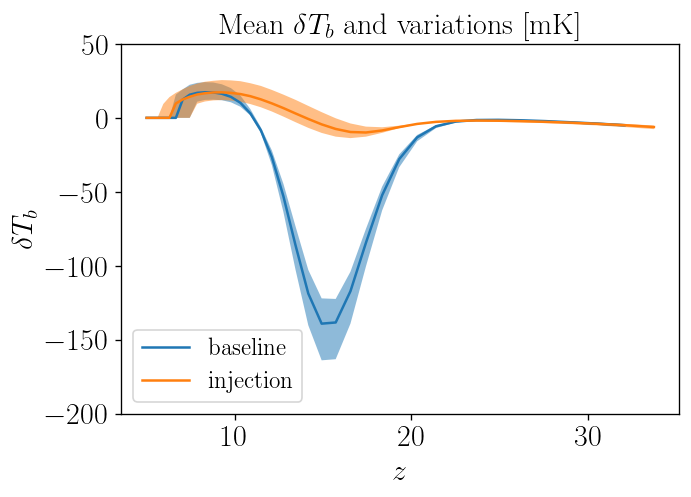

In [15]:
plot_data_base = np.load('../data/run_info/baseline_T_b.npy')
plot_data_inj  = np.load('../data/run_info/DH_T_b.npy')

fig, ax = plt.subplots()
ax.plot(z_arr[1:], plot_data_base[:,1], label='baseline')
ax.fill_between(z_arr[1:], plot_data_base[:,0], plot_data_base[:,2], alpha=0.5)
ax.plot(z_arr, plot_data_inj[:,1], label='injection')
ax.fill_between(z_arr, plot_data_inj[:,0], plot_data_inj[:,2], alpha=0.5)
ax.set(title=r'Mean $\delta T_b$ and variations [mK]', xlabel=r'$z$', ylabel=r'$\delta T_b$')
ax.set(ylim=(-200, 50));

ax.legend();

### 2.2 slices

In [20]:
! rm plots/tmp/*

In [23]:
title={
    'delta' : r'$\delta_\mathrm{DM/B}$',
    'T_s'   : r'$T_\mathrm{spin}$ [mK]',
    'x_e'   : r'$x_e$',
    'heat'  : r'$\epsilon_\mathrm{heat}$ [eV s$^{-1}$ per B]',
    'heat_dT' : r'heat $\Delta T$',
    'ion'   : r'$\epsilon_\mathrm{ion}$ [eV s$^{-1}$ per B]',
    'exc'   : r'$\epsilon_\mathrm{exc}$',
    'T_b'   : r'$T_b$ [mK]',
}
vrange={
    'delta' : (-0.25, 0.75),
    'T_s'   : (60., 100.),
    'x_e'   : (0., 0.002),
    'heat'  : (0., 7e-18),
    'heat_dT' : (0, 40),
    'ion'   : (0., 7e-18),
    'exc'   : (0., 1.),
    'T_b'   : (-20., 0.)
}

for i_z, record in enumerate(tqdm(records)):

    n_col = len(record.items())
    fig, axs = plt.subplots(1, n_col, figsize=(3*n_col, 4))
    for i, (k, x) in enumerate(record.items()):
        im = axs[i].imshow(x, vmin=vrange[k][0], vmax=vrange[k][1])
        axs[i].set(title=title[k], xticks=[], yticks=[])
        axs[i].text(28, 47, f'z={z_arr[i_z]:.3f}', color='w')
        fig.colorbar(im, ax=axs[i], orientation='horizontal', shrink=0.9)
    fig.savefig(f'plots/tmp/{i_z}.png')
    plt.close()

100%|██████████| 37/37 [00:34<00:00,  1.08it/s]


In [24]:
import glob
import contextlib
from PIL import Image

# filepaths
fp_in = "plots/tmp/*.png"
fp_out = "plots/DH.gif"

# use exit stack to automatically close opened images
flist = glob.glob(fp_in)
with contextlib.ExitStack() as stack:
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(flist, key=lambda x: int(os.path.basename(x).split('.')[0])))
    # extract  first image from iterator
    durations = np.full(len(flist), 500)
    durations[-1] = 1500
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=list(durations), loop=0)

### 2.3 lightcone

In [ ]:
p21c.run_lightcone(redshift=5)

# Archive

## A. Some uniform calculation for scale

In [25]:
swave_process = dict(
    mode = 'swave',
    mDM = 2e6, # [eV]
    sigmav = 1e-26, # [cm^3 s^-1]
)
decay_process = dict(
    mode = 'decay',
    mDM = 4e6, # [eV]
    lifetime = 3e25, # [s]
)
process = swave_process

$$\mathcal{E}^{inj}=\frac{1}{n_B}\frac{dE}{dtdV}=(1+z)^3\frac{\Omega_{DM}^2}{\Omega_B}\rho_c(1+B(z))m_pc^2\frac{\langle\sigma v\rangle}{m_{DM}}$$

In [26]:
E_inj = phys.omega_DM**2 / phys.omega_baryon * phys.rho_crit * phys.m_p * process['sigmav'] / process['mDM']
print(f"E_inj = (1+z)^3 (1+B) * {E_inj:.4e} eV / s")

E_inj = (1+z)^3 (1+B) * 3.1821e-20 eV / s


$$\epsilon^{DM}_{heat}=f_{heat}\mathcal{E}^{inj}$$

In [27]:
z_high, z_low = 34.91712652, 33.20678716
delta_B = jnp.array([0.])
x_e = jnp.array([0.1])
f_boxs = get_DH_f_boxs(delta_B, x_e, z=z_high, **process)

eDMheat = (1+z_high)**3 * f_boxs['heat'].flatten()[0] * E_inj
print(f"e_DM_heat = (1+B) * {eDMheat:.4e} eV / s")

e_DM_heat = (1+B) * 1.1110e-19 eV / s


$$\Delta T=\frac{2}{3k_B(1+x_e)}\,\Delta t\,\epsilon^{DM}_{heat}$$

In [28]:
dT =  2 / (3*phys.kB) * phys.dt_between_z(z_high, z_low) * eDMheat / (1+x_e[0])
print(f"dT = (1+B) * {1000*dT:.4f} mK")

dT = (1+B) * 149.2254 mK


## B. Plotting

[Text(0.5, 1.0, 'input ionization'), [], []]

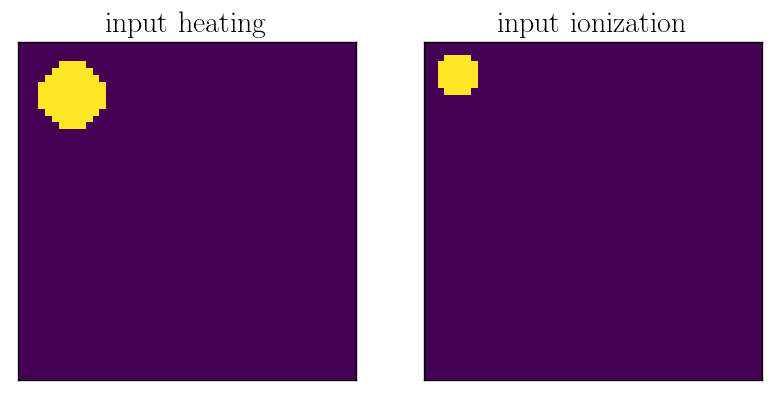

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
im0 = axs[0].imshow(input_heating.input_heating[25])
im1 = axs[1].imshow(input_ionization.input_ionization[25])

axs[0].set(title=r'input heating', xticks=[], yticks=[])
axs[1].set(title=r'input ionization', xticks=[], yticks=[])

#fig.colorbar(im0, ax=axs[0], orientation='horizontal')
#fig.colorbar(im1, ax=axs[1], orientation='horizontal')

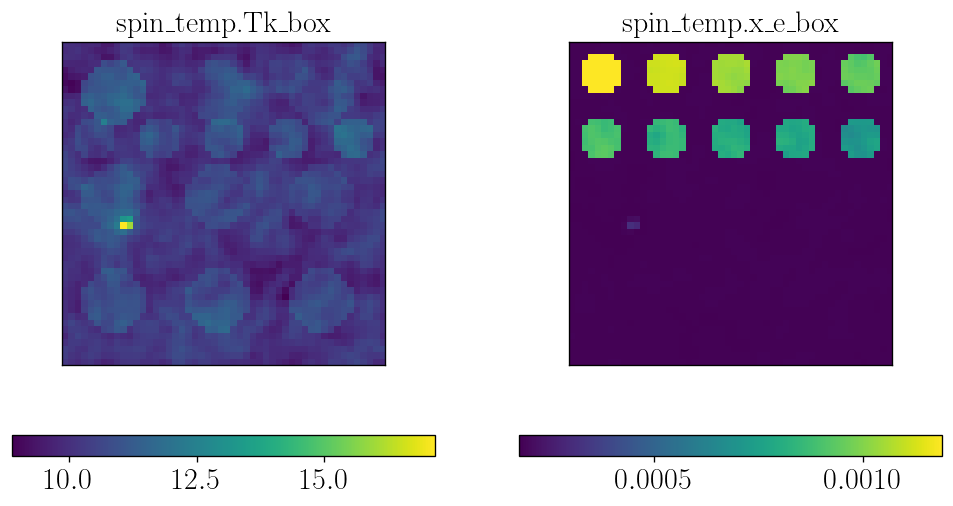

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
im0 = axs[0].imshow(spin_temp.Tk_box[25])
im1 = axs[1].imshow(spin_temp.x_e_box[25])

axs[0].set(title='spin_temp.Tk_box', xticks=[], yticks=[])
axs[1].set(title='spin_temp.x_e_box', xticks=[], yticks=[])

fig.colorbar(im0, ax=axs[0], orientation='horizontal')
fig.colorbar(im1, ax=axs[1], orientation='horizontal')